In [2]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [3]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [4]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/DDS-NBDS'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [5]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [6]:
len(all_data)

85

In [7]:
#collapsing all the data in one dataframe
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,location,target,type,quantile,target_end_date,value
2534,2020-07-27,42,1 wk ahead inc case,point,NaN,2020-08-01,5054.403600
5446,2020-07-27,42,2 wk ahead inc case,point,NaN,2020-08-08,4941.833200
8358,2020-07-27,42,3 wk ahead inc case,point,NaN,2020-08-15,3905.944000
11270,2020-07-27,42,4 wk ahead inc case,point,NaN,2020-08-22,3008.857800
2534,2020-08-03,42,1 wk ahead inc case,point,NaN,2020-08-08,5611.584782


In [8]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [ ]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

In [11]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(42, 7)

In [13]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
df_weekly.head(4)

,Date,forecast_date,location,target,type,quantile,value
0,2020-08-01,2020-07-27,42,1 wk ahead inc case,point,NaN,5054.403600
1,2020-08-08,2020-08-03,42,1 wk ahead inc case,point,NaN,5611.584782
2,2020-08-15,2020-08-10,42,1 wk ahead inc case,point,NaN,5169.395000
3,2020-08-22,2020-08-17,42,1 wk ahead inc case,point,NaN,4972.474800


In [16]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
##mask = (df_weekly['Date'] <= '2022-03-02')
#df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,location,target,type,quantile,value,dayRate
0,2020-08-01,2020-07-27,42,1 wk ahead inc case,point,NaN,5054.403600,722.057657
1,2020-08-08,2020-08-03,42,1 wk ahead inc case,point,NaN,5611.584782,801.654969
2,2020-08-15,2020-08-10,42,1 wk ahead inc case,point,NaN,5169.395000,738.485000
3,2020-08-22,2020-08-17,42,1 wk ahead inc case,point,NaN,4972.474800,710.353543
4,2020-08-29,2020-08-24,42,1 wk ahead inc case,point,NaN,4562.377800,651.768257


In [17]:
df_weekly.tail(3)

,Date,forecast_date,location,target,type,quantile,value,dayRate
32,2021-03-20,2021-03-15,42,1 wk ahead inc case,point,NaN,17039.5236,2434.217657
33,2021-03-27,2021-03-22,42,1 wk ahead inc case,point,NaN,16079.2540,2297.036286
34,2021-04-03,2021-03-29,42,1 wk ahead inc case,point,NaN,37470.6032,5352.943314


In [18]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
#del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[722.0576571428571, 722.0576571428571, 722.0576571428571, 722.0576571428571, 722.0576571428571, 722.0576571428571, 722.0576571428571, 801.6549689258931, 801.6549689258931, 801.6549689258931, 801.6549689258931, 801.6549689258931, 801.6549689258931, 801.6549689258931, 738.485, 738.485, 738.485, 738.485, 738.485, 738.485, 738.485, 710.3535428571429, 710.3535428571429, 710.3535428571429, 710.3535428571429, 710.3535428571429, 710.3535428571429, 710.3535428571429, 651.7682571428571, 651.7682571428571, 651.7682571428571, 651.7682571428571, 651.7682571428571, 651.7682571428571, 651.7682571428571, 573.2262285714286, 573.2262285714286, 573.2262285714286, 573.2262285714286, 573.2262285714286, 573.2262285714286, 573.2262285714286, 693.9323428571428, 693.9323428571428, 693.9323428571428, 693.9323428571428, 693.9323428571428, 693.9323428571428, 693.9323428571428, 536.5944285714286, 536.5944285714286, 536.5944285714286, 536.5944285714286, 536.5944285714286, 536.5944285714286, 536.5944285714286, 762.7

In [19]:
len(predictions)

245

In [23]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-08-01') & (df1['Date'] <= '2021-04-02')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-08-01,1320,1747.1,235406,25603978,251.2,312.9,35115.1,2860489,-5275.682283,2774.207671
1,2020-08-02,1154,1692.6,236560,25603978,218.5,315.3,35333.3,2860489,-5275.682283,2774.207671
2,2020-08-03,1674,1620.5,238234,25603978,337.4,301.8,35670.5,2860489,-5275.682283,2774.207671
3,2020-08-04,1446,1602.6,239680,25603978,311.3,305.1,35982.1,2860489,-5275.682283,2774.207671
4,2020-08-05,1620,1573.1,241300,25603978,349.2,311.3,36331.3,2860489,-5275.682283,2774.207671


In [24]:
df1_copy.tail(3)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
242,2021-03-31,7876,8335.0,2078504,25603978,1901.0,1906.7,558111.0,2860489,-5275.682283,2774.207671
243,2021-04-01,9970,8305.7,2088474,25603978,2427.6,1924.4,560538.5,2860489,-5275.682283,2774.207671
244,2021-04-02,10988,8698.9,2099462,25603978,2570.1,2020.2,563108.5,2860489,-5275.682283,2774.207671


In [25]:
#assigning predictions to the actual data
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [27]:
#renaming data for the graphs 
merged_df_new = df1_copy

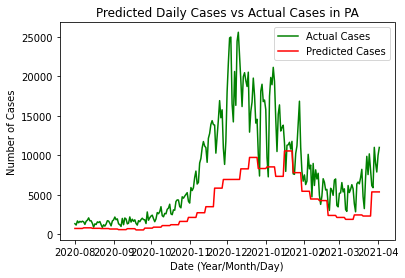

In [29]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['Actual'] - row["Prediction"]) / row['Actual'])
  error.append((abs(row['Actual'] - row["Prediction"])) / row['Actual'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

241
0.9836734693877551
4
0.01632653061224487
245
[0.305324983599746, 0.5211141165317246, 0.445605139055399, 0.5051512537494487, 0.47672652158884266, 0.5111859945573822, 0.4847975778111227, 0.4034854604200323, 0.5486033007334963, 0.5837175873731679, 0.64151213592233, 0.5625088862559242, 0.5640584415584415, 0.46017178362573097, 0.19461049562682212, 0.4552503505696757, 0.41869595510872104, 0.5422979749631811, 0.5187306620209059, 0.5560290357142857, 0.40803871428571425, 0.23140535714285718, 0.45137352092352095, 0.3584958098987627, 0.49000918846411806, 0.6170574282356891, 0.6083123454670329, 0.5277041614906832, 0.45510814774579034, 0.6555130837912088, 0.682247101678809, 0.7355967580390089, 0.6867616237314598, 0.7036058797459004, 0.5624227262813523, 0.41978901098901106, 0.29045772713993584, 0.6523385055825938, 0.41784199424736346, 0.6611658482142857, 0.6382000297929391, 0.46784329535495184, 0.6122872625928985, 0.754081380123085, 0.6492846872082166, 0.7160876039304611, 0.6699911263398348, 0.7

In [ ]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.694675016400254, 0.47888588346827543, 0.554394860944601, 0.4948487462505513, 0.5232734784111573, 0.48881400544261777, 0.5152024221888774, 0.5965145395799677, 0.4513966992665037, 0.4162824126268321, 0.35848786407766997, 0.4374911137440758, 0.43594155844155846, 0.539828216374269, 0.8053895043731779, 0.5447496494303243, 0.581304044891279, 0.4577020250368189, 0.4812693379790941, 0.44397096428571425, 0.5919612857142857, 0.7685946428571429, 0.548626479076479, 0.6415041901012373, 0.509990811535882, 0.3829425717643109, 0.39168765453296706, 0.4722958385093168, 0.5448918522542097, 0.34448691620879124, 0.317752898321191, 0.2644032419609911, 0.31323837626854023, 0.2963941202540996, 0.43757727371864774, 0.580210989010989, 0.7095422728600642, 0.34766149441740624, 0.5821580057526365, 0.3388341517857143, 0.3617999702070609, 0.5321567046450482, 0.38771273740710155, 0.245918619876915, 0.35071531279178336, 0.2839123960695389, 0.3300088736601652, 0.294832103610675, 0.39513580896276035, 0.66437648083623

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

     Unnamed: 0        Date  Actual forecast_date  location  \
0             0  2020-08-02    1154    2020-08-03        42   
1             1  2020-08-03    1674    2020-08-03        42   
2             2  2020-08-04    1446    2020-08-03        42   
3             3  2020-08-05    1620    2020-08-03        42   
4             4  2020-08-06    1532    2020-08-03        42   
..          ...         ...     ...           ...       ...   
240         240  2021-03-30    9032    2021-03-29        42   
241         241  2021-03-31    7876    2021-03-29        42   
242         242  2021-04-01    9970    2021-03-29        42   
243         243  2021-04-02   10988    2021-03-29        42   
244         244  2021-04-03    6518    2021-03-29        42   

                  target   type  quantile         value   Prediction  \
0    1 wk ahead inc case  point       NaN   5611.584782   801.654969   
1    1 wk ahead inc case  point       NaN   5611.584782   801.654969   
2    1 wk ahead inc case  p

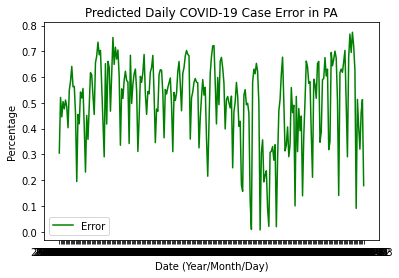

In [ ]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

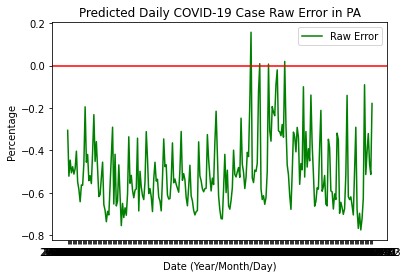

In [ ]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

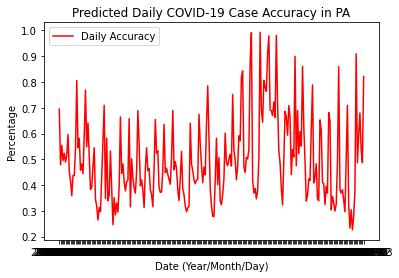

In [ ]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
length = len(accuracy)
amountOfWeeks = int(length / 7)
remainderDays = length % 7
print(remainderDays)

0


In [ ]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  =0   changed from 7 to 6 so its not 0

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [ ]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

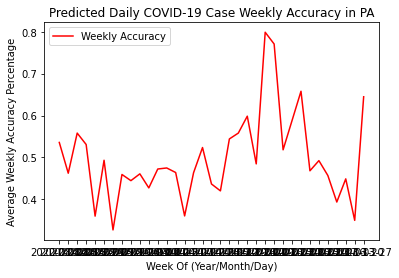

In [ ]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [ ]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

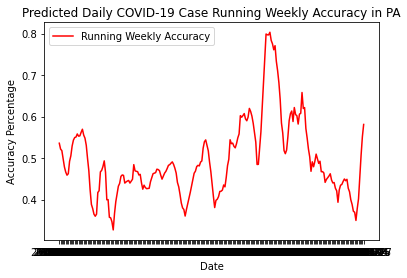

In [ ]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [ ]:
merged_df_new.dtypes